In [4]:
# import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import randint, uniform
import random
from sklearn.model_selection import KFold, cross_val_score
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
from scipy.stats import entropy
from imblearn.over_sampling import SMOTE,BorderlineSMOTE, ADASYN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [5]:
# read in dataset
X = pd.read_csv("phishing_site_urls.csv")
print(X.shape)
X['URL'].str.strip()
X


(549346, 2)


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


## Analysis the special Character on the bad URL

### Danger score = Bad probability ⋅ log(Frequency in bad URLs)

In [6]:
special_df = pd.DataFrame()

special_char = set()

# take a URL as an import parameter
def find_spec_char(x):
    special_char_in_x = re.findall(r'[^a-zA-Z0-9]',x)
    special_char.update(special_char_in_x)

    return None

X_bad = X[X['Label'] == 'bad']

print(X_bad.shape)

X_bad['URL'].apply(find_spec_char)

special_char = list(special_char)

special_char.remove('.')
special_char.remove('/')

#add the special char column to df

special_df['Special Chars'] = special_char

#print(X_bad[X_bad['URL']])

# Calculate the Frequency of each Character
special_df['Frequency in bad URLS'] = special_df['Special Chars'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex = True)].shape[0])

# Calculate the Probability of the Character (likelihood appear in all the URLs)
special_df['Bad Probability'] = special_df['Frequency in bad URLS'] / special_df['Special Chars'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex= True)].shape[0])

# Finally Calculate the Dangerous Score
special_df['Danger Score'] = special_df['Bad Probability'] * special_df['Frequency in bad URLS'].apply(math.log)

special_df.sort_values(by='Danger Score', ignore_index=True, ascending=False, inplace=True)

print(special_df)

(156422, 2)
    Special Chars  Frequency in bad URLS  Bad Probability  Danger Score
0               \                   6363         0.966874      8.468132
1               ;                  11294         0.906639      8.460778
2                                   1066         0.955197      6.659318
3               @                   1809         0.882870      6.621990
4               '                   3591         0.774089      6.336839
..            ...                    ...              ...           ...
167             Ë                      1         0.034483      0.000000
168             Â                      1         0.034483      0.000000
169             í                      1         0.040000      0.000000
170             µ                      1         0.041667      0.000000
171                                   1         0.041667      0.000000

[172 rows x 4 columns]


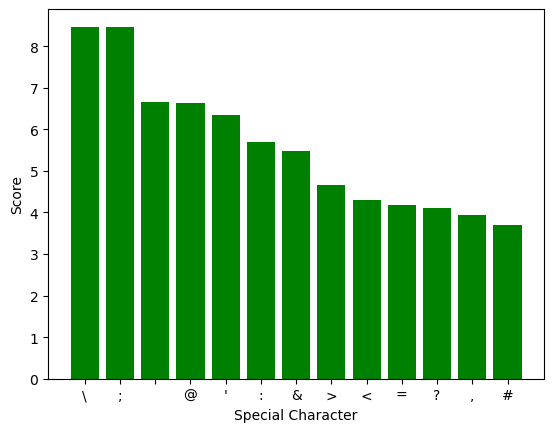

   Special Chars  Frequency in bad URLS  Bad Probability  Danger Score
0              \                   6363         0.966874      8.468132
1              ;                  11294         0.906639      8.460778
2                                  1066         0.955197      6.659318
3              @                   1809         0.882870      6.621990
4              '                   3591         0.774089      6.336839
5              :                   5193         0.665855      5.696431
6              &                  18020         0.560149      5.489035
7              >                    196         0.882883      4.659957
8              <                    167         0.839196      4.295000
9              =                  32588         0.401696      4.174305
10             ?                  32538         0.396346      4.118097
11             ,                    328         0.679089      3.933972
12             #                    347         0.632058      3.697114
13    

In [7]:
plt.bar(special_df['Special Chars'].head(13), special_df['Danger Score'].head(13), color = 'green')
plt.xlabel('Special Character')
plt.ylabel('Score')
plt.show()

danger_char = list(special_df['Special Chars'].head(13))
print(special_df.head(15))
print(danger_char)

## Analysis on the TLD of the given URL, Perform similar feature engineering 

In [8]:
TLD_df = pd.DataFrame()

TLD_list = pd.Series(X_bad['URL'].apply(lambda x: tldextract.extract(x).suffix).unique())

TLD_df['TLD'] = TLD_list

# Calculate the Frequence of each TLD
TLD_df['Frequency in Bad URL'] = TLD_df['TLD'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex= True)].shape[0])

# Calculate the Probability of each TLD in the whole data set
TLD_df ["Bad Probability"] = TLD_df['Frequency in Bad URL'] / TLD_df['TLD'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex= True)].shape[0])

# Calculate the Danger Score
TLD_df ['Danger Score'] = TLD_df['Bad Probability'] * TLD_df['Frequency in Bad URL'].apply(math.log)

TLD_df.sort_values(by='Danger Score', ascending= False, ignore_index= True, inplace= True)

TLD_df.head(13)

,TLD,Frequency in Bad URL,Bad Probability,Danger Score
0,com.br,4235,0.982599,8.205817
1,mx,3698,0.931486,7.652669
2,cm,10508,0.812495,7.523618
3,bf,3900,0.878576,7.264711
4,date,5402,0.775258,6.662977
5,run,4280,0.776629,6.493941
6,xyz,697,0.991465,6.490910
7,mg,2833,0.788917,6.271171
8,com.ar,622,0.922849,5.936630
9,ph,39001,0.559034,5.909739


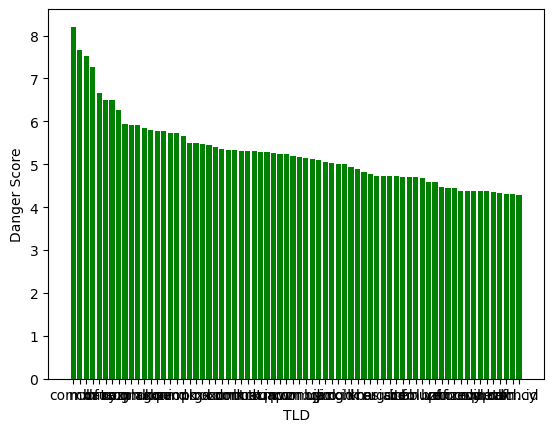

43
['com.br', 'mx', 'cm', 'bf', 'date', 'run', 'xyz', 'mg', 'com.ar', 'ph', 'com.cn', 'dk', 'gq', 'kz', 'ae', 'onion', 'md', 'com.mx', 'pk', 'cx', 'gd', 'sx', 'cd', 'cc', 'com.tr', 'mk', 'com.au', 'host', 'tk', 'co.in', 'qa', 'mp', 'pw', 'cz', 'cn', 'com.ua', 'com.vn', 'bg', 'jp', 'click', 'i.ng', 'co.id', 'co.kr']


In [9]:
plt.bar(TLD_df['TLD'].head(70), TLD_df['Danger Score'].head(70), color = 'green')
plt.xlabel('TLD')
plt.ylabel('Danger Score')
plt.show()

# Pick out the TLD that has the danger score greater than 5
Danger_Score_greater_than_5 = TLD_df[TLD_df['Danger Score'] > 5]
danger_TLD = list(Danger_Score_greater_than_5['TLD'])

print(len(danger_TLD))
print(danger_TLD)

## Feature Engineering

In [10]:
"""
URL length: total length of the URL string.

Number of dots: number of dots in the URL.

Number of slashes: number of slashes in the URL.

Percentage of numerical characters: percentage of numerical characters in the URL.

Dangerous characters: binary variable (True if there is a dangerous character in the URL and False otherwise)

Dangerous TLD: binary variable (True if the TLD of the URL is dangerous and False otherwise)

Entropy: Entropy of the URL.

IP address: binary variable (True if there is an IP address in the URL and False otherwise).  (IPv4 address format)
 
Domain name length: length of the main domain part.

Suspicious keywords: binary variable (True if there are suspicious keywords in the domain or path such as "login", "secure", "verify", "bank" and False otherwise). We'll use the following list of suspicious words
[secure, account, update, login, verify ,signin, bank,notify, click, inconvenient]

Repetitions: binary variable (True if the domain contains a substring of three identical characters and False otherwise).

Redirections
"""
def urlentropy(url):
    frequencies = Counter(url)
    prob = [frequencies[char] / len(url) for char in url]
    return entropy(prob, base=2)

def redirection(url):
  pos = url.rfind('//') #If the // is not found, it returns -1
  return pos>7

ip_pattern = r'[0-9]+(?:\.[0-9]+){3}'

sus_words = ['secure', 'account', 'update', 'login', 'verify' ,'signin', 'bank', 'notify', 'click', 'inconvenient']

X['URL length'] = X['URL'].apply(len)

X['Num of dots'] = X['URL'].apply(lambda x: x.count('.'))

X['Num of Slash'] = X['URL'].apply(lambda x: x.count('/'))

X['Precentage of numerical char'] = X['URL'].apply(lambda x: sum(c.isdigit() for c in x)) / X['URL length']

X['Dangerous Char'] = X['URL'].apply(lambda x: any(char in x for char in danger_char))

X['Dangerous TLD'] = X['URL']. apply(lambda x: tldextract.extract(x).suffix in danger_TLD)

X['Entropy'] = X['URL'].apply(urlentropy)

X['IP Address'] = X['URL'].apply(lambda x: bool(re.search(ip_pattern, x)))

X['Domain Name Length'] = X['URL'].apply(lambda x: len(tldextract.extract(x).domain))

X['Suspicious keywords'] = X['URL'].apply(lambda x: sum([word in x for word in sus_words]) != 0)

X['Repetitions'] = X['URL'].apply(lambda x: True if re.search(r'(.)\1{2,}', tldextract.extract(x).domain) else False)

X['Redirections'] = X['URL'].apply(redirection)


In [11]:
# X.drop(columns=['URL With Scheme'], inplace=True)
# Find the URL host name
def extract_hostname(url):
    try:
        # Remove square brackets if present
        url = url.replace("[", "").replace("]", "")
        
        # Prepend scheme if missing
        if "://" not in url:
            url = "http://" + url

        # Parse URL
        parsed_url = urlparse(url)
        return parsed_url.hostname
    except Exception as e:
        print(f"Error parsing URL '{url}': {e}")
        return None
    
X['Host Name'] = X['URL'].apply(lambda x: extract_hostname(x)) 

In [12]:
# Drop rows that have value of NA 
X = X.dropna(subset=['Host Name'])

In [13]:
# Calculate the length of host name
X['Hostname Length'] = X['Host Name'].apply(len)

/var/folders/60/pbzxbqv95bjg2dy4905y29y40000gn/T/ipykernel_90358/2524033572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Hostname Length'] = X['Host Name'].apply(len)


In [14]:
# Standardize the numerical features 

scaler = StandardScaler()

std_col = ['URL length', 'Num of dots', 'Num of Slash', 'Domain Name Length', 'Entropy', 'Hostname Length']

X[std_col] = scaler.fit_transform(X[std_col])

X

/var/folders/60/pbzxbqv95bjg2dy4905y29y40000gn/T/ipykernel_90358/3320965902.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[std_col] = scaler.fit_transform(X[std_col])


,URL,Label,URL length,Num of dots,Num of Slash,Precentage of numerical char,Dangerous Char,Dangerous TLD,Entropy,IP Address,Domain Name Length,Suspicious keywords,Repetitions,Redirections,Host Name,Hostname Length
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,4.001759,2.624200,4.791826,0.257778,True,False,3.053253,False,-0.799537,True,False,False,nobell.it,-0.703127
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,0.698141,1.958808,0.990595,0.012346,True,False,1.219075,False,-0.583082,False,False,False,www.dghjdgf.com,-0.185221
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,2.900553,3.289592,5.425364,0.265537,False,False,2.582332,False,0.499189,True,False,False,serviciosbys.com,-0.098904
3,mail.printakid.com/www.online.americanexpress....,bad,0.216363,2.624200,-0.276482,0.000000,False,False,0.717944,False,-0.150174,False,False,False,mail.printakid.com,0.073732
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,1.501104,-0.702761,4.791826,0.181034,True,False,1.742638,False,1.148552,False,False,True,thewhiskeydregs.com,0.160049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,-0.816018,0.628023,-0.910020,0.733333,False,False,-1.881338,True,0.932098,False,False,False,23.227.196.215,-0.271539
549342,apple-checker.org/,bad,-0.747192,-0.702761,-0.910020,0.000000,False,False,-1.461369,False,0.715643,False,False,False,apple-checker.org,-0.012586
549343,apple-iclods.org/,bad,-0.770134,-0.702761,-0.910020,0.000000,False,False,-1.498094,False,0.499189,False,False,False,apple-iclods.org,-0.098904
549344,apple-uptoday.org/,bad,-0.747192,-0.702761,-0.910020,0.000000,False,False,-1.485224,False,0.715643,False,False,False,apple-uptoday.org,-0.012586


In [15]:
# X.drop(columns=['URL_len'], inplace = True)
# X.drop(columns=['Domian Name Length'], inplace = True)

In [16]:
# Turn the boolean feature and target label into numericial 

X['IP Address'] = X['IP Address'].astype(int)
X['Suspicious keywords'] = X['Suspicious keywords'].astype(int)
X['Repetitions'] = X['Repetitions'].astype(int)
X['Redirections'] = X['Redirections'].astype(int)
X['Dangerous Char'] = X['Dangerous Char'].astype(int)
X['Dangerous TLD'] = X['Dangerous TLD'].astype(int)
X['Label'] = (X['Label'] == 'good').astype(int)

URL_list = list(X['URL'])
#print(len(URL_list))
X.drop(columns=['URL'], inplace = True)
X.drop(columns=['Host Name'], inplace= True)
X

/var/folders/60/pbzxbqv95bjg2dy4905y29y40000gn/T/ipykernel_90358/1164698702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['IP Address'] = X['IP Address'].astype(int)
/var/folders/60/pbzxbqv95bjg2dy4905y29y40000gn/T/ipykernel_90358/1164698702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Suspicious keywords'] = X['Suspicious keywords'].astype(int)
/var/folders/60/pbzxbqv95bjg2dy4905y29y40000gn/T/ipykernel_90358/1164698702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,Label,URL length,Num of dots,Num of Slash,Precentage of numerical char,Dangerous Char,Dangerous TLD,Entropy,IP Address,Domain Name Length,Suspicious keywords,Repetitions,Redirections,Hostname Length
0,0,4.001759,2.624200,4.791826,0.257778,1,0,3.053253,0,-0.799537,1,0,0,-0.703127
1,0,0.698141,1.958808,0.990595,0.012346,1,0,1.219075,0,-0.583082,0,0,0,-0.185221
2,0,2.900553,3.289592,5.425364,0.265537,0,0,2.582332,0,0.499189,1,0,0,-0.098904
3,0,0.216363,2.624200,-0.276482,0.000000,0,0,0.717944,0,-0.150174,0,0,0,0.073732
4,0,1.501104,-0.702761,4.791826,0.181034,1,0,1.742638,0,1.148552,0,0,1,0.160049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,0,-0.816018,0.628023,-0.910020,0.733333,0,0,-1.881338,1,0.932098,0,0,0,-0.271539
549342,0,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.461369,0,0.715643,0,0,0,-0.012586
549343,0,-0.770134,-0.702761,-0.910020,0.000000,0,0,-1.498094,0,0.499189,0,0,0,-0.098904
549344,0,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.485224,0,0.715643,0,0,0,-0.012586


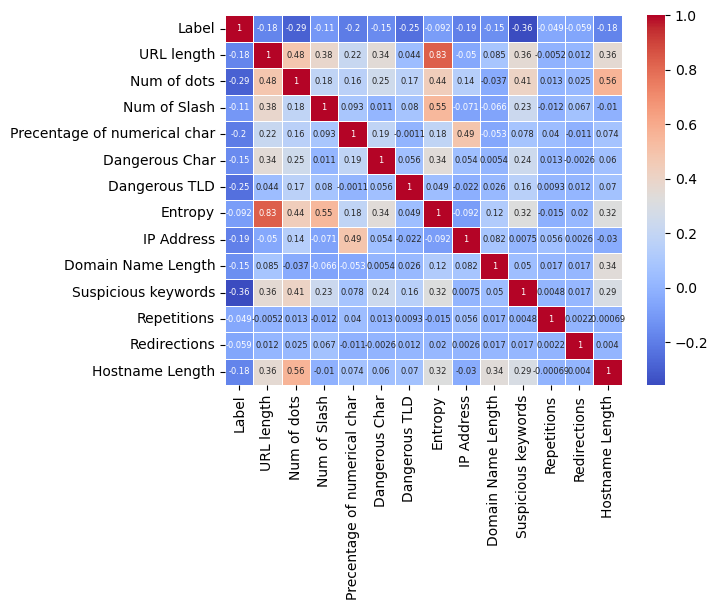

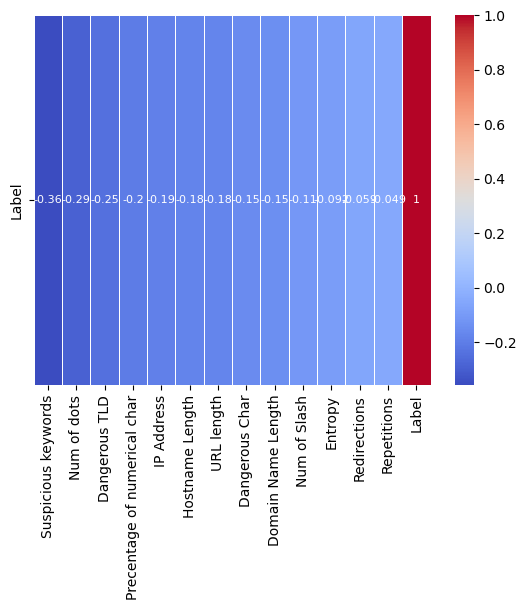

                                 Label
Suspicious keywords          -0.358204
Num of dots                  -0.290162
Dangerous TLD                -0.245735
Precentage of numerical char -0.204882
IP Address                   -0.192562
Hostname Length              -0.180065
URL length                   -0.175121
Dangerous Char               -0.151740
Domain Name Length           -0.145896
Num of Slash                 -0.111243
Entropy                      -0.092410
Redirections                 -0.058655
Repetitions                  -0.049426
Label                         1.000000


In [17]:
# Analysis the correlation between features
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 6})
plt.show()
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label').T, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.show()
print(corr_matrix[['Label']].sort_values(by='Label'))

## Skipping PCA here, may try it later

In [18]:
""" PCA """

' PCA '

## Handling Dataset imbalance (using SMOTE)

In [19]:
X['Label'].value_counts(normalize=True)

Label
1    0.716504
0    0.283496
Name: proportion, dtype: float64

In [20]:
X

,Label,URL length,Num of dots,Num of Slash,Precentage of numerical char,Dangerous Char,Dangerous TLD,Entropy,IP Address,Domain Name Length,Suspicious keywords,Repetitions,Redirections,Hostname Length
0,0,4.001759,2.624200,4.791826,0.257778,1,0,3.053253,0,-0.799537,1,0,0,-0.703127
1,0,0.698141,1.958808,0.990595,0.012346,1,0,1.219075,0,-0.583082,0,0,0,-0.185221
2,0,2.900553,3.289592,5.425364,0.265537,0,0,2.582332,0,0.499189,1,0,0,-0.098904
3,0,0.216363,2.624200,-0.276482,0.000000,0,0,0.717944,0,-0.150174,0,0,0,0.073732
4,0,1.501104,-0.702761,4.791826,0.181034,1,0,1.742638,0,1.148552,0,0,1,0.160049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,0,-0.816018,0.628023,-0.910020,0.733333,0,0,-1.881338,1,0.932098,0,0,0,-0.271539
549342,0,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.461369,0,0.715643,0,0,0,-0.012586
549343,0,-0.770134,-0.702761,-0.910020,0.000000,0,0,-1.498094,0,0.499189,0,0,0,-0.098904
549344,0,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.485224,0,0.715643,0,0,0,-0.012586


In [21]:
y = X['Label']
X.drop(columns=['Label'], inplace= True)
X

/var/folders/60/pbzxbqv95bjg2dy4905y29y40000gn/T/ipykernel_90358/3600836560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Label'], inplace= True)


,URL length,Num of dots,Num of Slash,Precentage of numerical char,Dangerous Char,Dangerous TLD,Entropy,IP Address,Domain Name Length,Suspicious keywords,Repetitions,Redirections,Hostname Length
0,4.001759,2.624200,4.791826,0.257778,1,0,3.053253,0,-0.799537,1,0,0,-0.703127
1,0.698141,1.958808,0.990595,0.012346,1,0,1.219075,0,-0.583082,0,0,0,-0.185221
2,2.900553,3.289592,5.425364,0.265537,0,0,2.582332,0,0.499189,1,0,0,-0.098904
3,0.216363,2.624200,-0.276482,0.000000,0,0,0.717944,0,-0.150174,0,0,0,0.073732
4,1.501104,-0.702761,4.791826,0.181034,1,0,1.742638,0,1.148552,0,0,1,0.160049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,-0.816018,0.628023,-0.910020,0.733333,0,0,-1.881338,1,0.932098,0,0,0,-0.271539
549342,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.461369,0,0.715643,0,0,0,-0.012586
549343,-0.770134,-0.702761,-0.910020,0.000000,0,0,-1.498094,0,0.499189,0,0,0,-0.098904
549344,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.485224,0,0.715643,0,0,0,-0.012586


In [22]:
smote = SMOTE()

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size= 0.8, random_state=42)

counter = Counter(train_y)
counter

Counter({1: 314383, 0: 124328})

In [23]:
sm_train_X, sm_train_y = smote.fit_resample(train_X, train_y)

counter = Counter(sm_train_y)
counter

Counter({1: 314383, 0: 314383})

# BaseLine Model

In [24]:
"""Linear Regression"""
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

LR = LogisticRegression()
LR.fit(sm_train_X, sm_train_y)
y_pred = LR.predict(test_X)

print("Accuracy:", accuracy_score(test_y, y_pred))
print(classification_report(test_y, y_pred))


Accuracy: 0.7321067123762286
              precision    recall  f1-score   support

           0       0.52      0.61      0.56     31138
           1       0.83      0.78      0.81     78540

    accuracy                           0.73    109678
   macro avg       0.68      0.69      0.69    109678
weighted avg       0.75      0.73      0.74    109678



In [25]:
""" Decision Tree"""
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(max_depth=3)  # Adjust max_depth based on data complexity
DT.fit(sm_train_X, sm_train_y)
y_pred = DT.predict(test_X)

print("Accuracy:", accuracy_score(test_y, y_pred))
print(classification_report(test_y, y_pred))

Accuracy: 0.7966319590072758
              precision    recall  f1-score   support

           0       0.83      0.36      0.50     31138
           1       0.79      0.97      0.87     78540

    accuracy                           0.80    109678
   macro avg       0.81      0.66      0.69    109678
weighted avg       0.80      0.80      0.77    109678



In [26]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
RF.fit(sm_train_X, sm_train_y)
y_pred = RF.predict(test_X)

print("Accuracy:", accuracy_score(test_y, y_pred))
print(classification_report(test_y, y_pred))

Accuracy: 0.8582304564269954
              precision    recall  f1-score   support

           0       0.80      0.67      0.73     31138
           1       0.88      0.93      0.90     78540

    accuracy                           0.86    109678
   macro avg       0.84      0.80      0.82    109678
weighted avg       0.85      0.86      0.85    109678



In [27]:
# from sklearn.neural_network import MLPClassifier

# MLP = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
# MLP.fit(sm_train_X, sm_train_y)
# y_pred = MLP.predict(test_X)

# print("Accuracy:", accuracy_score(test_y, y_pred))
# print(classification_report(test_y, y_pred))


In [28]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Define a similar MLP structure
# MLP = Sequential([
#     Dense(64, activation='relu', input_shape=(13,)),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')  # Binary classification
# ])
# MLP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# MLP.fit(sm_train_X, sm_train_y, epochs=10, batch_size=32)
# result = MLP.evaluate(test_X, test_y, verbose=0)
# y_pred = MLP.predict(test_X, batch_size=64, verbose=0)
# y_pred_bool = (y_pred > 0.5).astype(int)
# precision = precision_score(test_y, y_pred_bool)
# recall = recall_score(test_y, y_pred_bool)
# f1 = f1_score(test_y, y_pred_bool)
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print("\nClassification Report:\n", classification_report(test_y, y_pred_bool))
# print(result)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 64)  # Input size 13, hidden layer 64
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)  # Hidden layer size 32
        self.fc3 = nn.Linear(32, 1)   # Output layer size 1
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 32

# Convert data to PyTorch tensors
sm_train_X_tensor = torch.tensor(sm_train_X.values, dtype=torch.float32)
sm_train_y_tensor = torch.tensor(sm_train_y.values, dtype=torch.float32).unsqueeze(1)  # Add dimension for binary output
test_X_tensor = torch.tensor(test_X.values, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(sm_train_X_tensor, sm_train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
mlp = MLP()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# Training loop
mlp.train()
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = mlp(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluation
mlp.eval()
with torch.no_grad():
    y_pred = mlp(test_X_tensor)
    y_pred_bool = (y_pred > 0.5).int()
    precision = precision_score(test_y_tensor.numpy(), y_pred_bool.numpy())
    recall = recall_score(test_y_tensor.numpy(), y_pred_bool.numpy())
    f1 = f1_score(test_y_tensor.numpy(), y_pred_bool.numpy())
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:\n", classification_report(test_y_tensor.numpy(), y_pred_bool.numpy()))


Epoch [1/10], Loss: 0.3537
Epoch [2/10], Loss: 0.3958
Epoch [3/10], Loss: 0.3495
Epoch [4/10], Loss: 0.2898
Epoch [5/10], Loss: 0.3974
Epoch [6/10], Loss: 0.5195
Epoch [7/10], Loss: 0.3016
Epoch [8/10], Loss: 0.2149
Epoch [9/10], Loss: 0.3955
Epoch [10/10], Loss: 0.2505
Precision: 0.9311637080867851
Recall: 0.9016424751718869
F1 Score: 0.9161653405783039

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.83      0.80     31138
         1.0       0.93      0.90      0.92     78540

    accuracy                           0.88    109678
   macro avg       0.85      0.87      0.86    109678
weighted avg       0.89      0.88      0.88    109678



In [30]:

X_lstm = X
y_lstm = y
lstm_Xtrain, lstm_Xtest, lstm_ytrain, lstm_ytest = train_test_split(X_lstm, y_lstm, train_size = 0.8, random_state = 42)

In [31]:
lstm_sm = SMOTE()

sm_lstm_Xtrain, sm_lstm_ytrain = lstm_sm.fit_resample(lstm_Xtrain, lstm_ytrain)

In [32]:
X_lstm_3d = np.array(X_lstm).reshape((X_lstm.shape[0], 1, X_lstm.shape[1]))
sm_lstm_Xtrain_3d = np.array(sm_lstm_Xtrain).reshape((sm_lstm_Xtrain.shape[0], 1, sm_lstm_Xtrain.shape[1]))
sm_lstm_Xtest_3d = np.array(lstm_Xtest).reshape((lstm_Xtest.shape[0], 1, lstm_Xtest.shape[1]))

In [33]:
#Xtrain_lstm = np.array(X).reshape((X.shape[0], 1, X.shape[1]))

lstm = Sequential()
lstm.add(Input(shape=(X_lstm_3d.shape[1], X_lstm_3d.shape[2])))
lstm.add(LSTM(units=128))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
lstm.summary()
#X_train, X_test, y_train, y_test = train_test_split(Xtrain_lstm, y, train_size=0.8, random_state=42)
lstm.fit(sm_lstm_Xtrain_3d, sm_lstm_ytrain, verbose=0, epochs=10, batch_size=32, validation_split=0.2)
loss, accuracy, precision, recall = lstm.evaluate(sm_lstm_Xtest_3d, lstm_ytest, verbose=0)
y_pred = lstm.predict(sm_lstm_Xtest_3d, batch_size=64, verbose=0)
y_pred_bool = (y_pred > 0.5).astype(int)
f1 = f1_score(lstm_ytest, y_pred_bool)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,833 (284.50 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 0 (0.00 B)

Loss: 0.27499300241470337
Accuracy: 0.8873429298400879
Precision: 0.913567304611206
Recall: 0.9307359457015991
F1-Score: 0.9220716970660209


In [ ]:
X_lstm_3d = np.array(X_lstm).reshape((X_lstm.shape[0], 1, X_lstm.shape[1]))
sm_lstm_Xtrain_3d = np.array(sm_lstm_Xtrain).reshape((sm_lstm_Xtrain.shape[0], 1, sm_lstm_Xtrain.shape[1]))
sm_lstm_Xtest_3d = np.array(lstm_Xtest).reshape((lstm_Xtest.shape[0], 1, lstm_Xtest.shape[1]))

In [40]:
# Evaluate the model
loss, accuracy, precision, recall = lstm.evaluate(sm_lstm_Xtest_3d, lstm_ytest, verbose=0)
y_pred = lstm.predict(sm_lstm_Xtest_3d, batch_size=64, verbose=0)
y_pred_bool = (y_pred > 0.5).astype(int)

# Generate classification report
report = classification_report(lstm_ytest, y_pred_bool, target_names=['Phishing (0)', 'Safe (1)'])
print("Classification Report:")
print(report)

# Extract and print F1-score for the overall dataset
f1 = f1_score(lstm_ytest, y_pred_bool, average='weighted')  # Weighted for class imbalance
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Overall F1-Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

Phishing (0)       0.82      0.78      0.80     31138
    Safe (1)       0.91      0.93      0.92     78540

    accuracy                           0.89    109678
   macro avg       0.87      0.85      0.86    109678
weighted avg       0.89      0.89      0.89    109678

Loss: 0.27499300241470337
Accuracy: 0.8873429298400879
Overall F1-Score: 0.8864998633145929


In [34]:
"""Save The LSTM model and MLP Classifier"""
import joblib

lstm.save("lstm model.keras")

In [35]:
X

,URL length,Num of dots,Num of Slash,Precentage of numerical char,Dangerous Char,Dangerous TLD,Entropy,IP Address,Domain Name Length,Suspicious keywords,Repetitions,Redirections,Hostname Length
0,4.001759,2.624200,4.791826,0.257778,1,0,3.053253,0,-0.799537,1,0,0,-0.703127
1,0.698141,1.958808,0.990595,0.012346,1,0,1.219075,0,-0.583082,0,0,0,-0.185221
2,2.900553,3.289592,5.425364,0.265537,0,0,2.582332,0,0.499189,1,0,0,-0.098904
3,0.216363,2.624200,-0.276482,0.000000,0,0,0.717944,0,-0.150174,0,0,0,0.073732
4,1.501104,-0.702761,4.791826,0.181034,1,0,1.742638,0,1.148552,0,0,1,0.160049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,-0.816018,0.628023,-0.910020,0.733333,0,0,-1.881338,1,0.932098,0,0,0,-0.271539
549342,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.461369,0,0.715643,0,0,0,-0.012586
549343,-0.770134,-0.702761,-0.910020,0.000000,0,0,-1.498094,0,0.499189,0,0,0,-0.098904
549344,-0.747192,-0.702761,-0.910020,0.000000,0,0,-1.485224,0,0.715643,0,0,0,-0.012586


In [36]:
# """Convert MLP to tflite Format"""
# model = tf.keras.models.load_model('mlp.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TFLite model
# with open('mlp.tflite', 'wb') as f:
#     f.write(tflite_model)


In [37]:
"""Convert to Core ML"""
import torch.onnx

# Define dummy input matching the model's input shape
dummy_input = torch.randn(1, 13)  # Batch size of 1, input features 13

# Export to ONNX format
onnx_mlp_path = "mlp.onnx"
torch.onnx.export(
    mlp,                  # Trained PyTorch model
    dummy_input,            # Dummy input to specify input size
    onnx_mlp_path,        # Path to save ONNX model
    input_names=["input"],  # Input tensor name
    output_names=["output"],# Output tensor name
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},  # Dynamic batch size
    opset_version=13        # ONNX opset version
)
print(f"Model exported to {onnx_mlp_path}")


Model exported to mlp.onnx


In [38]:
"""To pytorch Mobile"""

import torch
mlp.eval()

# Convert the model to TorchScript
scripted_model = torch.jit.script(mlp)  # Or use torch.jit.trace for a traced model
scripted_model.save('mlp.pt')


In [39]:
from torch.utils.mobile_optimizer import optimize_for_mobile
optimized_model = optimize_for_mobile(scripted_model)
optimized_model.save('mlp_mobile.pt')
